In [20]:
%pip install onnx

                                              0.0/15.8 MB ? eta -:--:--
                                              0.4/15.8 MB 11.6 MB/s eta 0:00:02
     --                                       1.1/15.8 MB 14.0 MB/s eta 0:00:02
     -----                                    2.1/15.8 MB 16.4 MB/s eta 0:00:01
     -------                                  3.1/15.8 MB 18.1 MB/s eta 0:00:01
     -----------                              4.5/15.8 MB 20.5 MB/s eta 0:00:01
     ----------------                         6.6/15.8 MB 24.8 MB/s eta 0:00:01
     ---------------------                    8.3/15.8 MB 26.7 MB/s eta 0:00:01
     -------------------------               10.5/15.8 MB 31.2 MB/s eta 0:00:01
     ------------------------------          12.5/15.8 MB 38.5 MB/s eta 0:00:01
     ------------------------------------    14.7/15.8 MB 43.5 MB/s eta 0:00:01
     --------------------------------------  15.8/15.8 MB 46.9 MB/s eta 0:00:01
     --------------------------------------- 15.


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

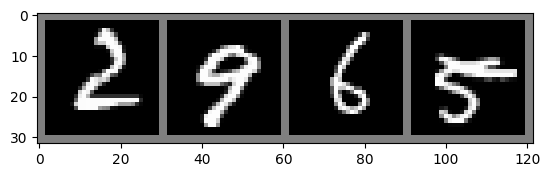

2     9     6     5    


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
print(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.076
[1,  4000] loss: 0.219
[1,  6000] loss: 0.139
[1,  8000] loss: 0.118
[1, 10000] loss: 0.095
[1, 12000] loss: 0.086
[1, 14000] loss: 0.081
[2,  2000] loss: 0.073
[2,  4000] loss: 0.058
[2,  6000] loss: 0.056
[2,  8000] loss: 0.057
[2, 10000] loss: 0.059
[2, 12000] loss: 0.052
[2, 14000] loss: 0.056
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

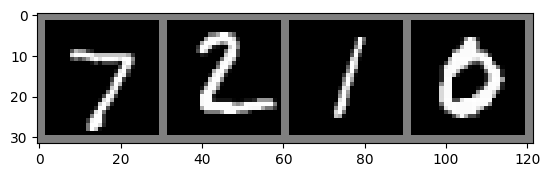

GroundTruth:  7     2     1     0    


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


In [14]:

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1



for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.7 %
Accuracy for class: 1     is 99.4 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 98.0 %
Accuracy for class: 4     is 99.2 %
Accuracy for class: 5     is 98.4 %
Accuracy for class: 6     is 98.3 %
Accuracy for class: 7     is 98.7 %
Accuracy for class: 8     is 99.3 %
Accuracy for class: 9     is 96.9 %


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [16]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
inputs, labels = data[0].to(device), data[1].to(device)

### Exportation du model pth en onnx

In [21]:
dummy_input = torch.randn(1, 1, 28, 28).cuda()

torch.onnx.export(
    net,      
    dummy_input,     
    "model.onnx",  
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={               
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
    opset_version=11
)